In [9]:
# Imports
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torchvision import datasets, transforms
from torchvision import models
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data import random_split
import tqdm
import wandb

# Set up GPU
gpu_avail = torch.cuda.is_available()
print(f"Is CUDA available?  {torch.cuda.is_available()}")
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print("Device", device)

Is CUDA available?  True
Device cuda


In [12]:
# Setup WandB Config
wandb.init(
    project="432-Task-01",

    config={
        "learning_rate": 1/32768,
        "architecture": "ResNet50 CNN",
        "dataset": "Colectoral Cancer",
        "epochs": 50,
    }
)

wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: dkaragiannakis99 (dkaragiannakis99-concordia-university). Use `wandb login --relogin` to force relogin


In [10]:
# Load in data
dataset = datasets.ImageFolder('Data/Prostate Cancer', transform=transforms.ToTensor())

# Split the data
train_set, test_set = random_split(dataset, [0.7, 0.3])

# Data loaders
train_loader = torch.utils.data.DataLoader(train_set, shuffle=True, batch_size=32)
test_loader = torch.utils.data.DataLoader(test_set,batch_size=32)

print("Categories: ", dataset.classes)
print("Number of Samples: ", len(dataset))
print("Samples in train set: ", len(train_set))
print("Samples in test set", len(test_set))

# Show some images
# def display(img):
#     plt.imshow(img, interpolation='nearest')

dataiter = iter(train_loader)
images, labels = next(dataiter) # Labels range from {0 = gland, 1 = nongland, 2 = tumor}
# display(images[0].permute(1,2,0))

Categories:  ['gland', 'nongland', 'tumor']
Number of Samples:  6000
Samples in train set:  4200
Samples in test set 1800


In [14]:
# Helper Functions for the model training loop
def accuracy(predictions, labels):
    _, predictions = torch.max(predictions, dim=1)
    return torch.tensor(torch.sum(predictions==labels).item() / len(predictions))

# performs forward propagation and returns loss
def step(model, batch, loss, testing=False):
    images, labels = batch
    images, labels = images.to(device), labels.to(device)
    predictions = model(images)

    if(testing):
        l = loss(predictions, labels)
        acc = accuracy(predictions, labels)
        return {'test loss':l.detach(), 'accuracy': acc}

    return loss(predictions, labels)

# Return mean loss and accuracy per epoch
def epoch_end_stats(predictions):
    batch_losses = [x['test loss'] for x in predictions]
    epoch_loss = torch.stack(batch_losses).mean() # Avg losses
    batch_accs = [x['accuracy'] for x in [predictions]]
    epoch_acc = torch.stack(batch_accs).mean() # Avg accuracies
    logs = {'test loss': epoch_loss.item(), 'accuracy': epoch_acc.item()} 
    wandb.log(logs)
    return logs # Return means

# Evaluate loop
def evaluate(model, loss, test_loader):
    model.eval()
    predictions = [step(model, batch, loss, testing=True) for batch in test_loader]
    return epoch_end_stats(predictions)


In [17]:
# Import ResNet
rs50 = models.resnet50(num_classes=3)
rs50.to(device)

# Define loss function and optimizer
loss = nn.CrossEntropyLoss()

# Values found from https://catalog.ngc.nvidia.com/orgs/nvidia/resources/resnet_50_v1_5_for_pytorch
optimizer = optim.Adam(rs50.parameters(), lr=0.032, weight_decay=1/32768)

# Create training loop
def train(model, loss, optimizer, train_loader, test_loader, epochs):
    model.train()
    results = []
    for epoch in range(epochs):
        losses = [] # delete if tracking accuracy doesnt work
        with tqdm.tqdm(total=len(train_loader), desc=f'Epoch {epoch + 1}/{epochs}') as pbar:
          for batch in train_loader:
              # Perform forward propagation
              l = step(model, batch, loss)

              # Record loss, and perform back propagation
              losses.append(l)
              optimizer.zero_grad() # reset gradients
              l.backward()
              optimizer.step()
              pbar.update()

          # After each batch we evaluate the model:
        #   result = evaluate(model, loss, test_loader)
        #   result['train loss'] = torch.stack(losses).mean().item()
        #   pbar.set_postfix(train_loss=result['train loss'], test_loss=result['test loss'], accuracy=result['accuracy'])
        #   results.append(result)
        results.append(losses)
    print("Training Complete!")
    return results

In [18]:
# Train the model
results = train(rs50,loss=loss,optimizer=optimizer, train_loader=train_loader, test_loader=test_loader, epochs=50)
wandb.finish()

Epoch 50/50: 100%|██████████| 132/132 [07:10<00:00,  3.26s/it]


Training Complete!


0.08236438781023026


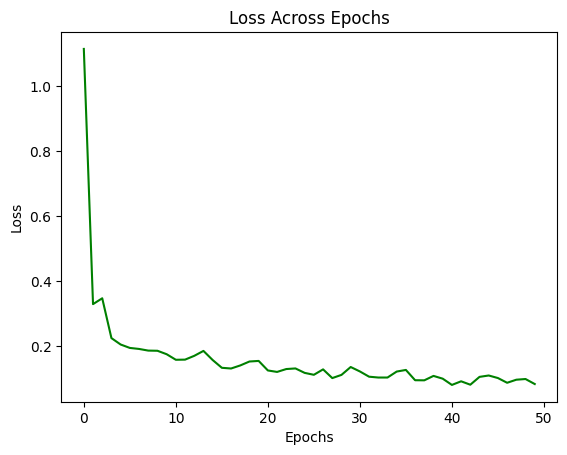

In [32]:
avg_results = []
for result in results:
    result = torch.stack(result).mean().item()
    avg_results.append(result)

print(avg_results[-1])
plt.plot(avg_results, color="green")
plt.title("Loss Across Epochs")
plt.ylabel("Loss") 
plt.xlabel("Epochs")
plt.show()


In [35]:
# Evaluate
@torch.no_grad()
def eval(model, test_loader):
    model.eval()
    accuracies = []
    for batch in test_loader:
        images, labels = batch
        images, labels = images.to(device), labels.to(device)
        predictions = model(images)
        accuracies.append(accuracy(predictions, labels))
    print("Finished Evaluation")
    return accuracies

accuracies = eval(rs50, test_loader=test_loader)


Finished Evaluation


tensor(0.2500)


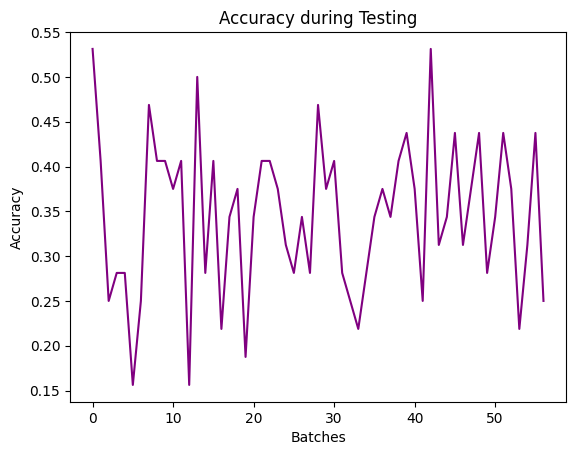

In [36]:
print(accuracies[-1])
plt.plot(accuracies, color="purple")
plt.title("Accuracy during Testing")
plt.ylabel("Accuracy") 
plt.xlabel("Batches")
plt.show()

In [37]:
# Save model for later? 
torch.save(rs50.state_dict(), "colocteral-cancer-model-01.tar")